In [1]:
import sys;sys.path.append('..')
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from utils.plot import plot_heatmap
from utils.dataloader import synthesize_data, generate_logged_data
from src.listwise import ListwiseRecommender
from conf.settings.default import DataConfig
from utils.metrics import calc_dcg
%matplotlib inline

In [2]:
params = DataConfig(
    n_users=100, 
    n_items=500, 
    mu_u=1,
    mu_i=100, 
    dirichlet_noise=(0.3, 0.01), 
    n_factors=10, 
    k=15, 
    n_rankings_per_user=5,
    p_power=100.0,
)
Vui = synthesize_data(params)
dataset = generate_logged_data(params, Vui)

In [3]:
dataset.train[:,:,5].mean()

0.010222222222222223

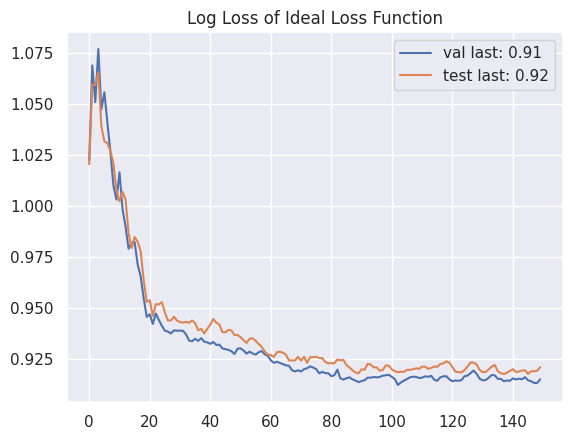

In [27]:
# ideal
train = dataset.train[:,:,[0,1,2]]
val = dataset.val[:,:,[0,1,2]]
test = dataset.test

model = ListwiseRecommender(
        n_users=params.n_users,
        n_items=params.n_items,
        n_factors=2,
        lr=0.3,
        n_epochs=150,
        reg=0.01,
        seed=params.seed,
        batch_size=150,
        n_positions=params.k,
        scale=.001
)

val_loss, test_ideal_loss, ideal_ndcgs = model.fit((train, val, test))

plt.title('Log Loss of Ideal Loss Function')
plt.plot(val_loss, label=f"val last: {val_loss[-1]:.2f}")
plt.plot(test_ideal_loss, label=f"test last: {test_ideal_loss[-1]:.2f}")
plt.legend()
plt.show()

In [28]:
scores = model.predict(user_ids=test[:,:,0].reshape(-1), item_ids=test[:,:,1].reshape(-1))
print(f'mean: {scores.mean():.3f}, min: {scores.min():.3f}, max: {scores.max():.3f}, std: {scores.std():.3f}')

mean: 0.067, min: 0.004, max: 0.452, std: 0.048


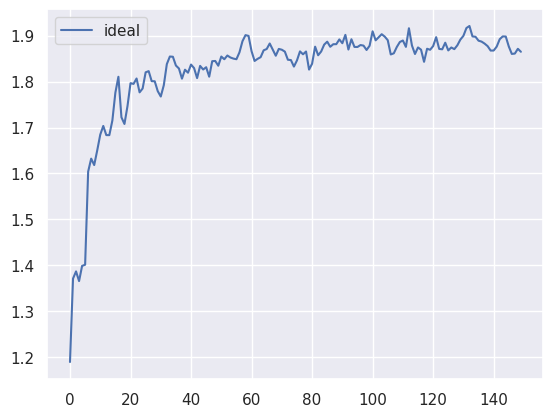

In [29]:
plt.plot(ideal_ndcgs, label="ideal")
plt.legend()
plt.show()

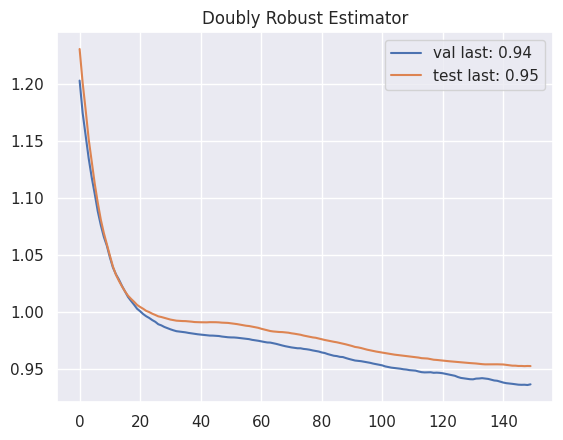

In [34]:
# DR

expo_labels = dataset.train[:,:,4]
pscores = dataset.train[:,:,3]

np.random.seed(1)
mu_hat = np.clip(dataset.train[:,:,2] + np.random.uniform(-0.01, 0.01), 0, 1)
clicks = dataset.train[:,:,5]

X_ui = (expo_labels/pscores)*(clicks-mu_hat)+mu_hat

train = np.concatenate([dataset.train[:,:,[0,1]], X_ui[:,:,None]], axis=2)

expo_labels = dataset.val[:,:,4]
pscores = dataset.val[:,:,3]

np.random.seed(1)
mu_hat = np.clip(dataset.val[:,:,2] + np.random.uniform(-0.01, 0.01), 0, 1)
clicks = dataset.val[:,:,5]

X_ui = (expo_labels/pscores)*(clicks-mu_hat)+mu_hat

val = np.concatenate([dataset.val[:,:,[0,1]], X_ui[:,:,None]], axis=2)

model = ListwiseRecommender(
        n_users=params.n_users,
        n_items=params.n_items,
        n_factors=2,
        lr=0.03,
        n_epochs=150,
        reg=0.01,
        seed=params.seed,
        batch_size=150,
        n_positions=params.k,
)

val_loss, test_dr_loss, dr_ndcgs = model.fit((train, val, test))

plt.title('Doubly Robust Estimator')
plt.plot(val_loss, label=f"val last: {val_loss[-1]:.2f}")
plt.plot(test_dr_loss, label=f"test last: {test_dr_loss[-1]:.2f}")
plt.legend()
plt.show()

In [35]:
scores = model.predict(user_ids=test[:,:,0].reshape(-1), item_ids=test[:,:,1].reshape(-1))
print(f'mean: {scores.mean():.3f}, min: {scores.min():.3f}, max: {scores.max():.3f}, std: {scores.std():.3f}')

mean: 0.067, min: 0.000, max: 0.860, std: 0.043


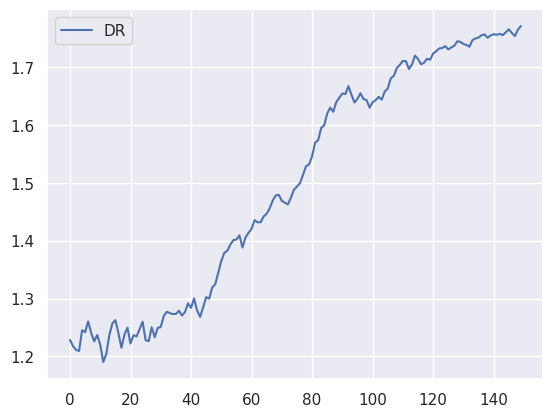

In [36]:
plt.plot(dr_ndcgs, label="DR")
plt.legend()
plt.show()

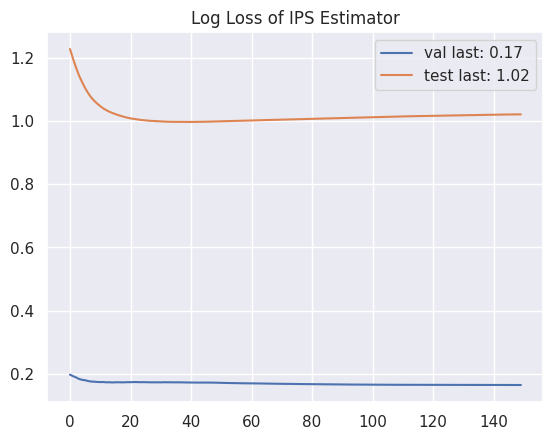

In [38]:
# IPS
pscores = dataset.train[:,:,3]
clicks = dataset.train[:,:,5]

X_ui = clicks/pscores
train = np.concatenate([dataset.train[:,:,[0,1]], X_ui[:,:,None]], axis=2)

pscores = dataset.val[:,:,3]
clicks = dataset.val[:,:,5]

X_ui = clicks/pscores
val = np.concatenate([dataset.val[:,:,[0,1]], X_ui[:,:,None]], axis=2)

model = ListwiseRecommender(
        n_users=params.n_users,
        n_items=params.n_items,
        n_factors=2,
        lr=0.01,
        n_epochs=150,
        reg=0.01,
        seed=params.seed,
        batch_size=150,
        n_positions=params.k,
)

val_loss, test_ips_loss, ips_ndcgs = model.fit((train, val, test))

plt.title('Log Loss of IPS Estimator')
plt.plot(val_loss, label=f"val last: {val_loss[-1]:.2f}")
plt.plot(test_ips_loss, label=f"test last: {test_ips_loss[-1]:.2f}")
plt.legend()
plt.show()


In [39]:
scores = model.predict(user_ids=test[:,:,0].reshape(-1), item_ids=test[:,:,1].reshape(-1))
print(f'mean: {scores.mean():.3f}, min: {scores.min():.3f}, max: {scores.max():.3f}, std: {scores.std():.3f}')

mean: 0.067, min: 0.000, max: 0.990, std: 0.039


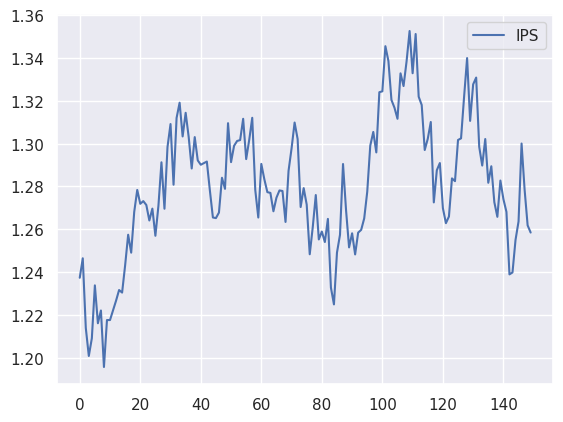

In [40]:
plt.plot(ips_ndcgs, label="IPS")
plt.legend()
plt.show()

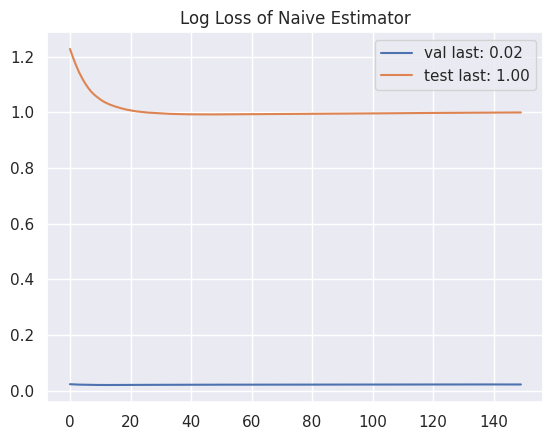

In [41]:
# Naive
train = dataset.train[:,:,[0,1,5]]
val = dataset.val[:,:,[0,1,5]]

model = ListwiseRecommender(
        n_users=params.n_users,
        n_items=params.n_items,
        n_factors=2,
        lr=0.01,
        n_epochs=150,
        reg=0.01,
        seed=params.seed,
        batch_size=150,
        n_positions=params.k,
)

val_loss, test_naive_loss, naive_ndcgs = model.fit((train, val, test))

plt.title('Log Loss of Naive Estimator')
plt.plot(val_loss, label=f"val last: {val_loss[-1]:.2f}")
plt.plot(test_naive_loss, label=f"test last: {test_naive_loss[-1]:.2f}")
plt.legend()
plt.show()

In [42]:
scores = model.predict(user_ids=test[:,:,0].reshape(-1), item_ids=test[:,:,1].reshape(-1))
print(f'mean: {scores.mean():.3f}, min: {scores.min():.3f}, max: {scores.max():.3f}, std: {scores.std():.3f}')

mean: 0.067, min: 0.000, max: 0.903, std: 0.032


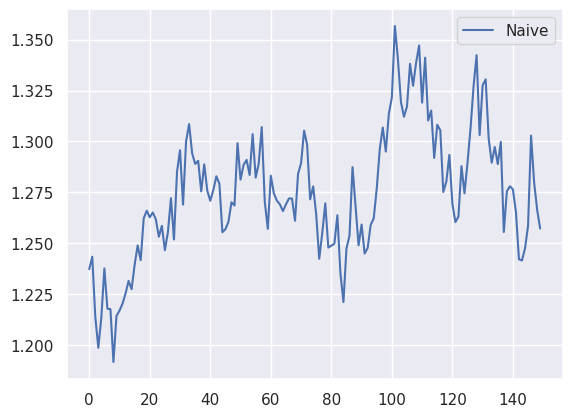

In [43]:
plt.plot(naive_ndcgs, label="Naive")
plt.legend()
plt.show()